# Gesture Classification

This notebook is used to train classification models from csv dataset. 

> shift and rotation 

<a href="#evaluation">Go to Evaluation Cell</a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [30]:
# set up
from DataPrepare import HandDataPrepare
HandLandmarkPrepare = HandDataPrepare()

dataset = 'datasets/HandLandmarks.csv'
model_save_path = 'models/gesture_classifier.hdf5'
tflite_save_path = 'models/gesture_classifier.tflite'

LABELS = HandLandmarkPrepare.LABELS
NUM_CLASSES = HandLandmarkPrepare.NUM_CLASSES

## Dataset Preparation

In [31]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

In [32]:
X_dataset

array([[ 1.        ,  0.        ,  0.        , ..., -0.14635985,
        -0.1572016 , -0.04949586],
       [ 0.        ,  0.        ,  0.        , ...,  0.08369572,
        -0.11977903, -0.02191895],
       [ 0.        ,  0.        ,  0.        , ...,  0.08063158,
        -0.08024994, -0.0584185 ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.06896959,
        -0.02961229,  0.02221191],
       [ 1.        ,  0.        ,  0.        , ..., -0.07367362,
        -0.04976007, -0.01578337],
       [ 0.        ,  0.        ,  0.        , ...,  0.09230869,
        -0.07786263,  0.02421767]], dtype=float32)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [34]:
y_train

array([15, 17, 17, ...,  5,  0, 15])

In [35]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.13414203e-02, -4.54763100e-02, -2.65603457e-02,  5.81061393e-02,
       -1.10490575e-01, -3.20240073e-02,  7.37368166e-02, -1.61537692e-01,
       -3.67456116e-02,  9.92792174e-02, -1.98530942e-01, -4.20627408e-02,
        1.45698336e-17, -1.25715956e-01, -1.79737080e-02, -5.02719637e-03,
       -1.82447821e-01, -3.12963538e-02, -6.19568024e-03, -2.16056406e-01,
       -3.89906392e-02, -9.72928759e-03, -2.45008841e-01, -4.50358428e-02,
       -3.34548913e-02, -1.06711268e-01, -1.90593414e-02, -7.12594986e-02,
       -1.53687000e-01, -4.11496684e-02, -9.15932581e-02, -1.85151294e-01,
       -5.53851463e-02, -1.13570079e-01, -2.09756643e-01, -6.29772842e-02,
       -5.98498508e-02, -7.87225813e-02, -2.32318621e-02, -6.98077977e-02,
       -1.02155603e-01, -6.37801141e-02, -3.92142497e-02, -7.53470138e-02,
       -7.24179000e-02, -1.83381848e-02, -5.48758619e-02, -6.69651479e-02,
       -7.69788772e-02, -

In [36]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(13500,) (13500, 64) (4500,) (4500, 64)


## Model Building

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                     

In [39]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [40]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [41]:
es_callback

In [42]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
101/106 [===========================>..] - ETA: 0s - loss: 1.8077 - accuracy: 0.4702
Epoch 1: saving model to models\gesture_classifier.hdf5
106/106 [==============================] - 3s 7ms/step - loss: 1.7802 - accuracy: 0.4779 - val_loss: 2.7809 - val_accuracy: 0.0911
Epoch 2/1000
 36/106 [=========>....................] - ETA: 0s - loss: 0.9405 - accuracy: 0.7138

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 90/106 [========================>.....] - ETA: 0s - loss: 0.8486 - accuracy: 0.7370
Epoch 2: saving model to models\gesture_classifier.hdf5
106/106 [==============================] - 0s 4ms/step - loss: 0.8235 - accuracy: 0.7446 - val_loss: 2.4788 - val_accuracy: 0.1598
Epoch 3/1000
 89/106 [========================>.....] - ETA: 0s - loss: 0.5879 - accuracy: 0.8198
Epoch 3: saving model to models\gesture_classifier.hdf5
106/106 [==============================] - 0s 4ms/step - loss: 0.5788 - accuracy: 0.8218 - val_loss: 1.7578 - val_accuracy: 0.5138
Epoch 4/1000
 90/106 [========================>.....] - ETA: 0s - loss: 0.4815 - accuracy: 0.8505
Epoch 4: saving model to models\gesture_classifier.hdf5
106/106 [==============================] - 0s 4ms/step - loss: 0.4718 - accuracy: 0.8526 - val_loss: 0.9043 - val_accuracy: 0.8300
Epoch 5/1000
 92/106 [=========================>....] - ETA: 0s - loss: 0.4332 - accuracy: 0.8659
Epoch 5: saving model to models\gesture_classifier.hdf5
106/

In [43]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

36/36 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9636


In [44]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [45]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 123ms/step
[1.4255357e-10 2.0693610e-03 9.9790925e-01 2.1218602e-09 5.3085608e-07
 8.1199710e-07 1.3303290e-08 1.8114788e-05 1.3483956e-11 1.1361016e-06
 2.3606578e-10 4.3372148e-07 4.9368215e-10 5.0499433e-14 1.8664753e-07
 8.0974322e-10 1.1312780e-07 5.1962828e-10]
2


# Confusion matrix

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

<a id="evaluation"></a>

### Evaluation 

141/141 [==============================] - 0s 1ms/step


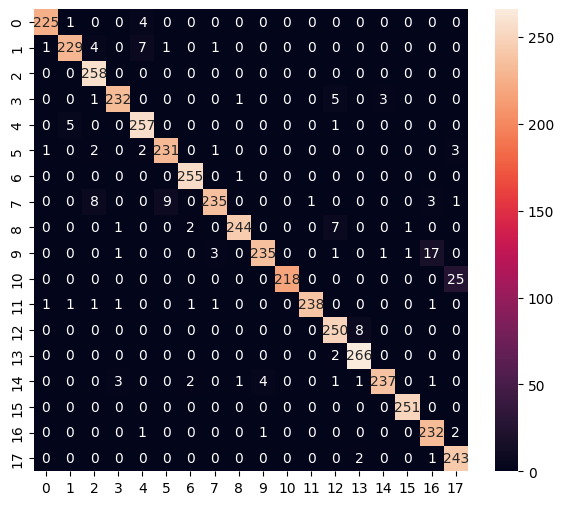

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       230
           1       0.97      0.94      0.96       243
           2       0.94      1.00      0.97       258
           3       0.97      0.96      0.97       242
           4       0.95      0.98      0.96       263
           5       0.96      0.96      0.96       240
           6       0.98      1.00      0.99       256
           7       0.98      0.91      0.94       257
           8       0.99      0.96      0.97       255
           9       0.98      0.91      0.94       259
          10       1.00      0.90      0.95       243
          11       1.00      0.97      0.98       245
          12       0.94      0.97      0.95       258
          13       0.96      0.99      0.98       268
          14       0.98      0.95      0.97       250
          15       0.99      1.00      1.00       251
          16       0.91      0.98      0.95       236
     

In [47]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## Convert to model for Tensorflow-Lite

In [48]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpsosjuelo\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpsosjuelo\assets


38608

### Inference test

In [50]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [51]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [52]:
np.array([X_test[0]])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.99099388e-02, -2.41483971e-02,
        -1.54375145e-02,  2.39135642e-02, -6.26356155e-02,
        -1.91490427e-02, -3.98712931e-03, -8.55632350e-02,
        -2.00938787e-02, -2.91798506e-02, -8.10021311e-02,
        -1.77233256e-02,  5.50141447e-18, -8.94276127e-02,
        -8.16768035e-03, -1.62761025e-02, -1.09593287e-01,
        -2.11114436e-02, -5.79045014e-03, -8.07730630e-02,
        -2.66316850e-02,  3.23471334e-03, -7.17237592e-02,
        -2.86693592e-02, -1.84570067e-02, -8.33197460e-02,
        -6.19823486e-03, -3.28780822e-02, -1.02508478e-01,
        -1.88707262e-02, -1.64903663e-02, -6.87060580e-02,
        -1.99374296e-02, -1.02171022e-02, -6.31176010e-02,
        -1.76238585e-02, -3.49727608e-02, -7.50619620e-02,
        -7.07816007e-03, -4.93596643e-02, -9.18483362e-02,
        -2.29614191e-02, -2.99078990e-02, -5.78949973e-02,
        -1.91795137e-02, -2.19379980e-02, -5.19322641e-0

In [53]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.75663095e-10 2.44797184e-03 9.97525990e-01 2.19297469e-09
 5.96208508e-07 1.05250047e-06 1.26161614e-08 2.23817606e-05
 1.41370917e-11 1.27656949e-06 2.72140782e-10 5.16100954e-07
 5.82142168e-10 6.03028369e-14 1.75916853e-07 9.30981126e-10
 1.68522490e-07 7.04599046e-10]
2
CPU times: total: 0 ns
Wall time: 3 ms
